# 导入包

In [1]:
import pdb, os, shutil, datetime, math, sys, time

In [2]:
import scipy.stats as ss

In [3]:
import json

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import tensorflow as tf

In [7]:
strJobsDir = "../jobs_nobranch"

# 帧同步锁前

因为在MNIST中的样本有784个属性。用于分类的模型也只有2层。所以在整个解扰前的训练中，我使用的模型的层数均不变。

只随着样本属性的增加，增加每层的神经元个数。

## 工具函数

### 训练函数
训练模型，模型用全局变量表示。

如果在某个迭代的最终损失不小于前一次迭代，终止循环，返回前一次迭代的生成器的三个元素。

In [23]:
def fn_train(oGAN): 
    def fn_getGLoss(tensorInput):
        # Apperant loss
        tensorEncodedSamples = oGAN.oSeqGe(tensorInput)
        tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
        tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorInput, tensorFakeSamples))

        # Latent loss
        tensorEncoded1Samples = oGAN.oSeqGe1(tensorFakeSamples)
        tensorLatentLoss = \
        tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSamples, tensorEncoded1Samples))

        # Feature matching loss
        tensorPredFeatures = oGAN.oSeqDInner(tensorFakeSamples)
        tensorTrueFeatures = oGAN.oSeqDInner(tensorInput)
        tensorFeatureLoss = tf.reduce_mean(tf.losses.mean_squared_error(tensorPredFeatures, tensorTrueFeatures))

        tensorGLoss = tensorApperantLoss + tensorLatentLoss + tensorFeatureLoss
        return tensorGLoss
    # 在每个epoch后存储最小的ALoss和对应的
    fGLossLast = np.inf

    timeStart = datetime.datetime.now()
    g_nStep = 0
    for nEpoch in range(g_nEpochs):
        for tensorBatch in oDataset:
            # Train discriminator
            # Generator fake samples
            tensorEncodedSamples = oGAN.oSeqGe(tensorBatch)
            tensorFakeSamples = oGAN.oSeqGd(tensorEncodedSamples)
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with real samples
                tensorLabels = tf.random.uniform(minval=0.7, maxval=1.2, seed=42, shape=(tensorBatch.shape[0], 1))
                tensorPreds = oGAN.oSeqD(tensorBatch)
                tensorDLossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossR, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            with tf.GradientTape() as oGradientTapeD:
                # Train discriminator with fake samples
                tensorLabels = tf.random.uniform(minval=0., maxval=0.3, seed = 42, shape=(tensorFakeSamples.shape[0], 1))
                tensorPreds = oGAN.oSeqD(tensorFakeSamples)
                tensorDLossF = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tensorLabels, tensorPreds))
            listDGradients = oGradientTapeD.gradient(tensorDLossF, oGAN.oSeqD.trainable_variables)
            oOptimizerD.apply_gradients(zip(listDGradients, oGAN.oSeqD.trainable_variables))
            tensorDLoss = tensorDLossR + tensorDLossF
            with oSummaryWriterDLoss.as_default():
                tf.summary.scalar("D_Loss", tensorDLoss, g_nStep)

            # Train genertor
            with tf.GradientTape() as oGradientTapeG:
                tensorGLoss = fn_getGLoss(tensorBatch)
            # Insert all generator trainable variables into a list
            listTrainableGVariables = []
            listTrainableGVariables.extend(oGAN.oSeqGe.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGd.trainable_variables)
            listTrainableGVariables.extend(oGAN.oSeqGe1.trainable_variables)

            listGGradients = oGradientTapeG.gradient(tensorGLoss, listTrainableGVariables)
            oOptimizerG.apply_gradients(zip(listGGradients, listTrainableGVariables))
            with oSummaryWriterALoss.as_default():
                tf.summary.scalar("A_loss", tensorGLoss, g_nStep)

            g_nStep = g_nStep + 1
            
        # 在整个训练集上计算generator的损失，并比较和上一次迭代的损失，如果小于上一次迭代，更新损失和最有模型；反之停止训练
        tensorGLossOverTotalSamples = fn_getGLoss(g_tensorNormalTrainingSamples)
        if fGLossLast > tensorGLossOverTotalSamples.numpy():
            fGLossLast = tensorGLossOverTotalSamples.numpy()
            global oSeqGe, oSeqGd, oSeqGe1
            oSeqGe = oGAN.oSeqGe
            oSeqGd = oGAN.oSeqGd
            oSeqGe1 = oGAN.oSeqGe1
        # 输出进度
        fn_printBar(nEpoch)
    timeEnd = datetime.datetime.now()
    g_nTime = (timeEnd - timeStart).seconds

### 算分函数

计算分数的函数
通过输入样本集和Ge，Gd，Ge1输出样本集中每个样本的分数的函数。

In [22]:
def fn_scoreForASample(npSample):
    tensorSample = tf.constant(npSample[np.newaxis, :])
    tensorEncodedSample = oSeqGe(tensorSample)
    tensorFakeSample = oSeqGd(tensorEncodedSample)
    # Apperant loss
    tensorApperantLoss = tf.reduce_mean(tf.losses.mean_absolute_error(tensorSample, tensorFakeSample))

    # Latent loss
    tensorEncoded1Sample = oSeqGe1(tensorFakeSample)
    tensorLatentLoss = \
        tf.reduce_mean(tf.losses.mean_squared_error(tensorEncodedSample, tensorEncoded1Sample))

    tensorScore = tensorApperantLoss + tensorLatentLoss
    return tensorScore.numpy()

def fn_score(pdDfSamples):
    if pdDfSamples.empty:
        pdDfScores = pd.DataFrame(columns=["score"])
        return pdDfScores
    
    pdDfScores = pd.DataFrame(data=np.apply_along_axis(fn_scoreForASample, 1, pdDfSamples.values), columns=["score"], \
         index=pdDfSamples.index)
    return pdDfScores

### 输出训练进度函数

In [21]:
def fn_printBar(nEpoch):
    sys.stdout.write(f"\r{nEpoch:d}/{g_nEpochs}")
    sys.stdout.flush()

### 通过任务文件夹路径获取解调器文件夹路径函数

In [20]:
def fn_getDemodDirsOfAJob(strJobDir):
    liststrDemodDirs = [os.path.join(strJobDir, strName) for strName in os.listdir(strJobDir) if "Demod" in strName]
    return liststrDemodDirs

## 中频输入

### 构造建立模型

In [42]:
# 2
class GANinput(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(2,)))
        self.oSeqGe.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(1,)))
        self.oSeqGd.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(2, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(2,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(2,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [43]:
# 新建模型
oGANinput = GANinput()

### 构造数据集

In [44]:
g_nFeatures = 2
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/input/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [45]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/input/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

In [79]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedAbnormalSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedAbnormalSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/input/samples/abnormal/preprocessed/samples.csv")
        pdDfPreprocessedAbnormalSamples = pd.read_csv(strPreprocessedAbnormalSamplesFile, index_col="RECTIME")
            
        listPreprocessedAbnormalSamples.append(pdDfPreprocessedAbnormalSamples)
pdDfPreprocessedAbnormalSamples = pd.concat(listPreprocessedAbnormalSamples, ignore_index=True)
g_tensorAbnormalSamples = tf.constant(pdDfPreprocessedAbnormalSamples.values, dtype=tf.float32)

In [71]:
abnormal_points

array([], shape=(0, 2), dtype=float32)

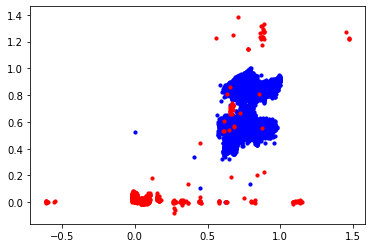

In [81]:
normal_points = g_tensorNormalTrainingSamples.numpy()
abnormal_points = g_tensorAbnormalSamples.numpy()
plt.scatter(normal_points[:, 0], normal_points[:, 1], c="b", s=10)
plt.scatter(abnormal_points[:, 0], abnormal_points[:, 1], c="r", s=10)

In [84]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedAbnormalSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedAbnormalSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/input/samples/abnormal/preprocessed/samples.csv")
        pdDfPreprocessedAbnormalSamples = pd.read_csv(strPreprocessedAbnormalSamplesFile, index_col="RECTIME")
            
        for row in pdDfPreprocessedAbnormalSamples.index:
            point = pdDfPreprocessedAbnormalSamples.loc[row, :]
            if point[0] > 0.0 and point[0] < 0.5:
                print(strDemodDir, "--->", row)
        listPreprocessedAbnormalSamples.append(pdDfPreprocessedAbnormalSamples)
pdDfPreprocessedAbnormalSamples = pd.concat(listPreprocessedAbnormalSamples, ignore_index=True)
g_tensorAbnormalSamples = tf.constant(pdDfPreprocessedAbnormalSamples.values, dtype=tf.float32)

../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:05:57
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:05:58
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:05:59
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:00
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:01
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:02
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:03
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:04
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:05
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:06
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:06:07
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:15:06
../jobs_nobranch\JOB201912276594418\KJ_HDemodQH1 ---> 2019-12-28 08:15:07
../jobs_nobranch\JOB201912276594418\KJ

../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:26
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:27
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:28
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:29
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:30
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:31
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:32
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:33
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:34
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:35
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:36
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:38
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH5 ---> 2020-01-16 00:43:39
../jobs_nobranch\JOB202001158086775\KJ

../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:50
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:51
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:52
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:53
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:54
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:56
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:57
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:58
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:41:59
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:42:00
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:42:01
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:42:02
../jobs_nobranch\JOB202001158086775\KJ_HDemodQH6 ---> 2020-01-16 00:42:03
../jobs_nobranch\JOB202001158086775\KJ

### 训练

In [46]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [47]:
strD = "(2,1)_D_long"
strA = "(2,1)_A_long"
strRootDir = "logs/nobranch/sync/input"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [48]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [49]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANinput)

265/10000

KeyboardInterrupt: 

保存模型

In [32]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/input"
strModelsDir = os.path.join(strRootDir, "(2,1)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [33]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [34]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估
然后利用训练好的模型算出测试集样本的分数，存档。

从文件夹中载入训练好的模型。

遍历每个解调器的测试集，将相应的分数存入preprocessed/scores.csv中

In [35]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

计算测试样本分数并存档
执行后：
* samples/
    * normal/
        * test/
            * preprocessed/
                * samples.csv
                * scores.csv
    * abnormal/
        * preprocessed/
            * samples.csv
            * scores.csv

In [36]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/input/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [37]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/input/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [38]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/input/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [39]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeaninput = np.mean(npNormalScores)
fSigmainput = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeaninput else ss.norm.sf(x, fMeaninput, fSigmainput), 1, \
     npAbnormalScores[:, np.newaxis])

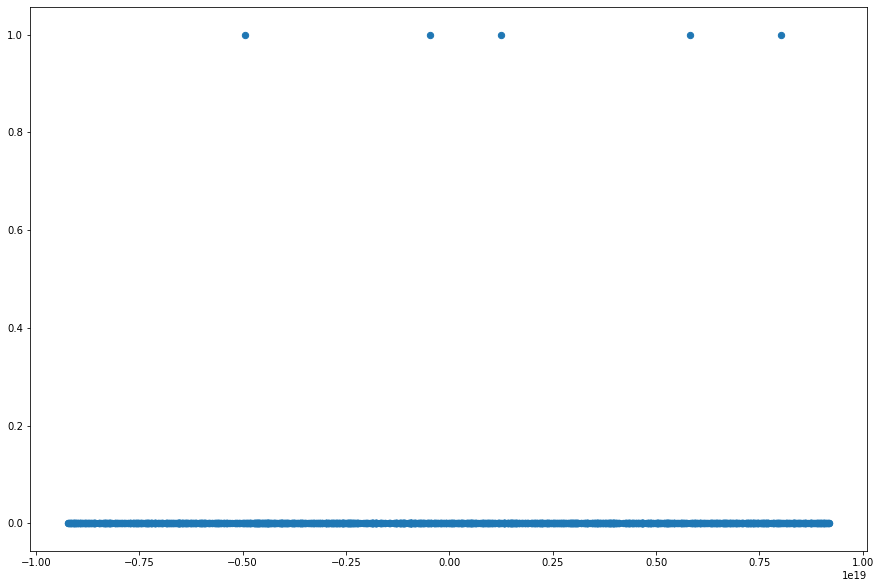

In [40]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

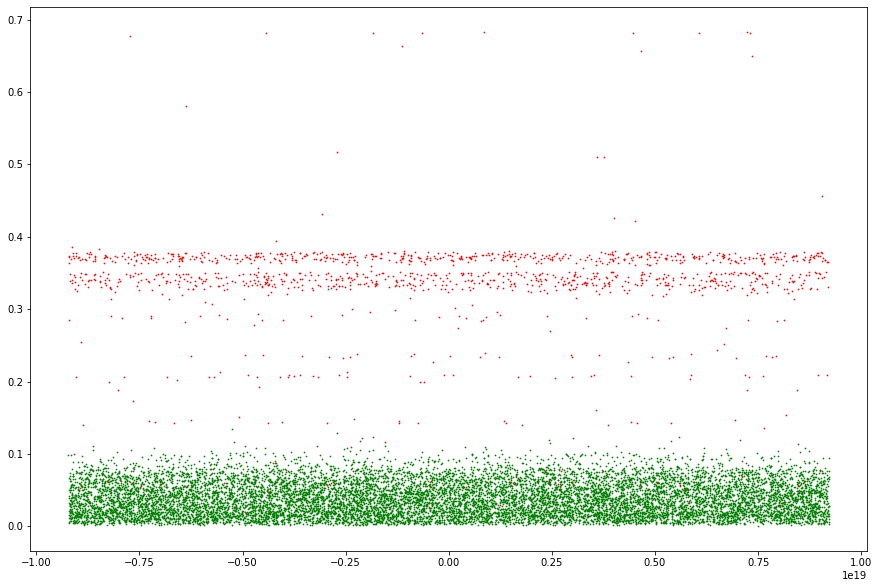

In [41]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.scatter(npNormalX, npNormalScores, c="green", s=0.5)
plt.scatter(npAbnormalX, npAbnormalScores, c="red", s=0.5)
plt.show()

## 载波同步

### 构造建立模型

In [84]:
# 4参数
class GANcarrier(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(4,)))
        self.oSeqGe.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(2,)))
        self.oSeqGd.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(4, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(4,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(4,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [85]:
# 新建模型
oGANcarrier = GANcarrier()

### 构造数据集

In [86]:
g_nFeatures = 4
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX


oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/carrier/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [87]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/carrier/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [88]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [92]:
strD = "(4,2)_D"
strA = "(4,2)_A"
strRootDir = "logs/nobranch/sync/carrier"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [93]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [94]:
oSeqGe = None
oSeqGd = None 
oSeqGe1 = None
fn_train(oGANcarrier)

166/10000

KeyboardInterrupt: 

In [95]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/carrier"
strModelsDir = os.path.join(strRootDir, "(4,2)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [96]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [97]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [98]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [99]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/carrier/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [17]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/carrier/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [18]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/carrier/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [19]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeancarrier = np.mean(npNormalScores)
fSigmacarrier = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeancarrier else ss.norm.sf(x, fMeancarrier, fSigmacarrier), 1, \
     npAbnormalScores[:, np.newaxis])

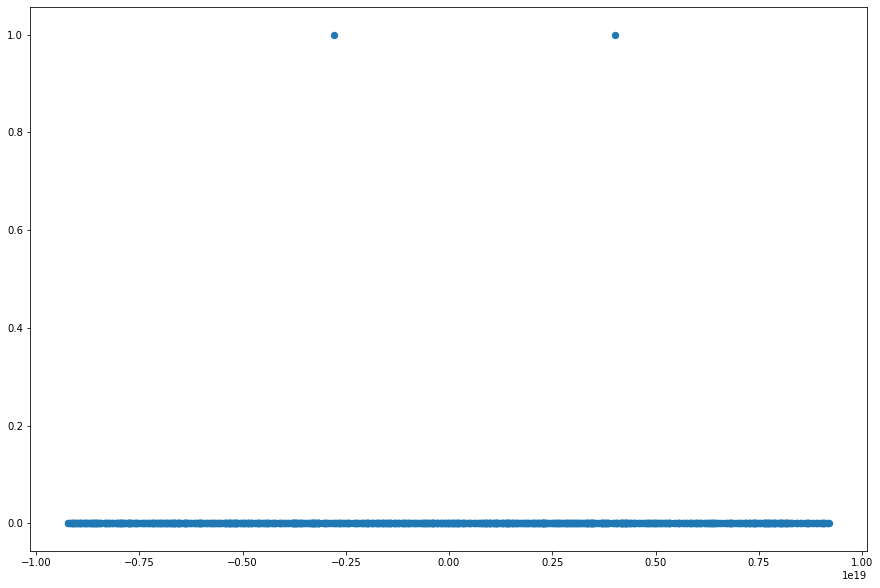

In [20]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 比特同步

### 构造建立模型

In [129]:
# 10参数
class GANbit(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(10,)))
        self.oSeqGe.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(5,)))
        self.oSeqGd.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(10, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(10,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(10,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [130]:
# 新建模型
oGANbit = GANbit()

### 构造数据集

In [131]:
g_nFeatures = 10
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [132]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [133]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [134]:
strD = "(10,5)_D"
strA = "(10,5)_A"
strRootDir = "logs/nobranch/sync/bit"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [136]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [137]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANbit)

397/10000

KeyboardInterrupt: 

In [105]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/bit"
strModelsDir = os.path.join(strRootDir, "(10,5)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [139]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [140]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [106]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [142]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [21]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [22]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [23]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanbit = np.mean(npNormalScores)
fSigmabit = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanbit else ss.norm.sf(x, fMeanbit, fSigmabit), 1, \
     npAbnormalScores[:, np.newaxis])

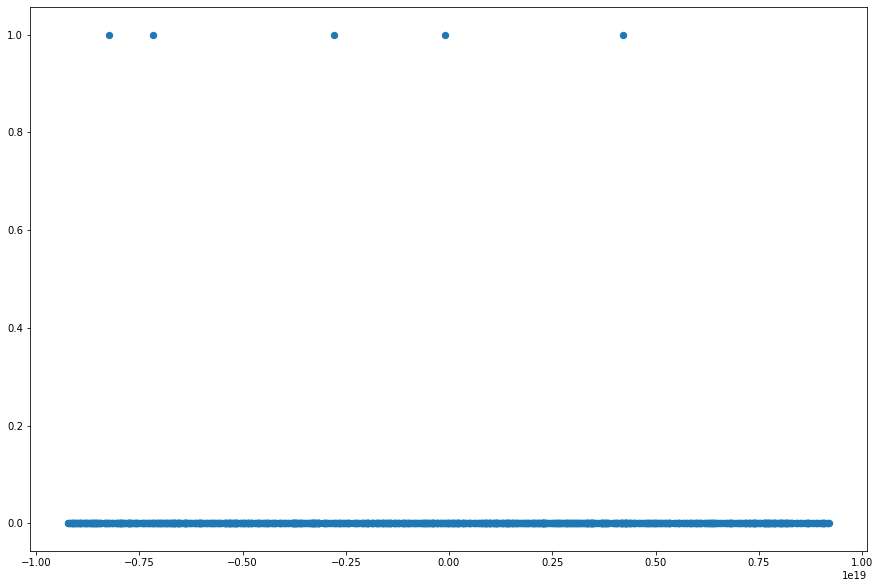

In [24]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 维特比译码

### 构造建立模型

In [175]:
# 17参数
class GANvi(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(17,)))
        self.oSeqGe.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(8,)))
        self.oSeqGd.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(17, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(17,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(17,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [176]:
# 新建模型
tf.keras.backend.clear_session()
oGANvi = GANvi()

### 构造数据集

In [177]:
g_nFeatures = 17
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/vi/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [160]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/vi/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [178]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [179]:
strD = "(17,8)_D"
strA = "(17,8)_A"
strRootDir = "logs/nobranch/sync/vi"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [180]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [181]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANvi)

1591/10000

KeyboardInterrupt: 

In [112]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/vi"
strModelsDir = os.path.join(strRootDir, "(17,8)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [182]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [183]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [113]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [114]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [25]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/vi/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [26]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/vi/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [27]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanvi = np.mean(npNormalScores)
fSigmavi = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanvi else ss.norm.sf(x, fMeanvi, fSigmavi), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

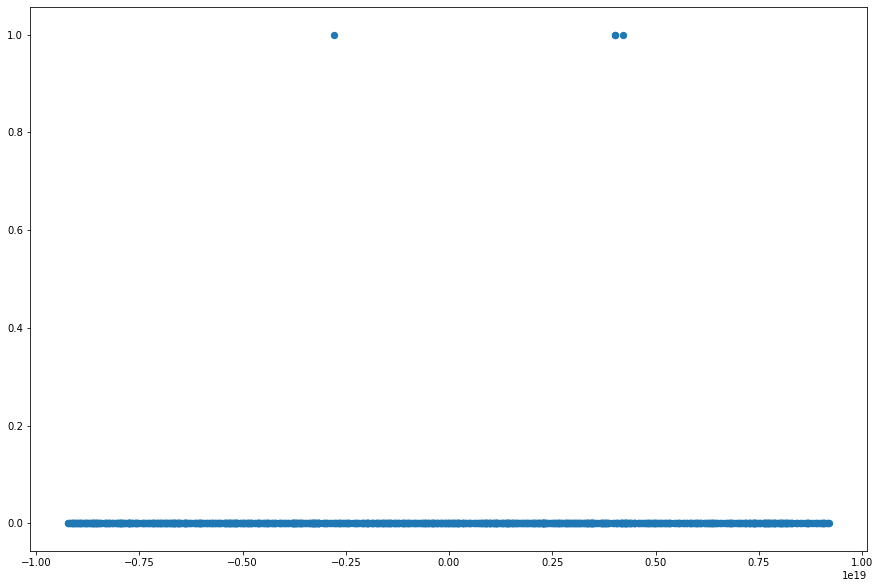

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 帧同步

### 构造建立模型

In [157]:
# 25参数
class GANframe(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(28,)))
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(14,)))
        self.oSeqGd.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(28, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(28,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(28,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [198]:
# 新建模型
tf.keras.backend.clear_session()
oGANframe = GANframe()

### 构造数据集

In [199]:
g_nFeatures = 28
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

# 为了把不做帧同步的部分也作为训练集
oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/frame/samples/normal/train/preprocessed/samples*.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [200]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/frame/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
        
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                           "parts/sync/frame/samples/normal/train/preprocessed/samples_noframe.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [201]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [202]:
strD = "(28,14)_D"
strA = "(28,14)_A"
strRootDir = "logs/nobranch/sync/frame"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)

In [203]:
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [204]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [205]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANframe)

727/10000

KeyboardInterrupt: 

In [206]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/frame"
strModelsDir = os.path.join(strRootDir, "(28,14)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [207]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [208]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [209]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [210]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/frame/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/frame/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [29]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/frame/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [30]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/frame/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [31]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanframe = np.mean(npNormalScores)
fSigmaframe = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeanframe, fSigmaframe), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

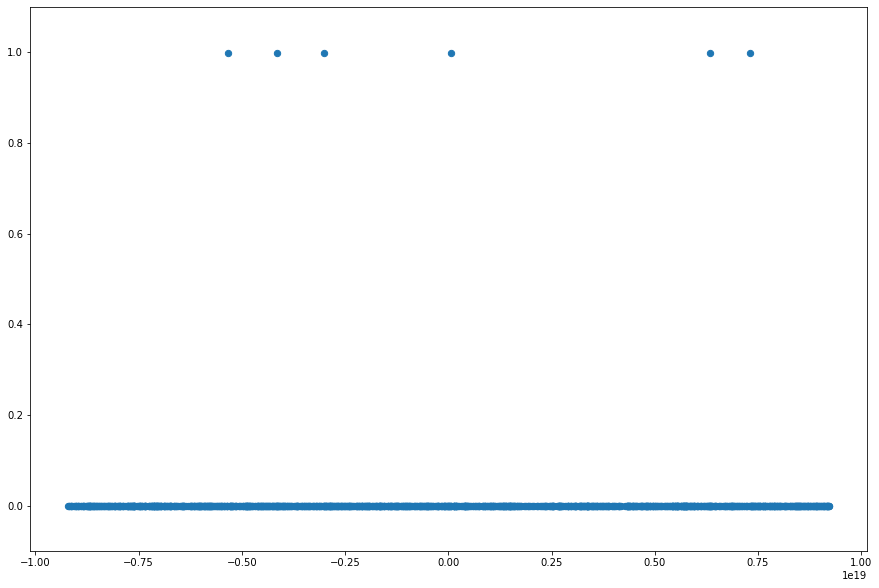

In [214]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.ylim([-0.1, 1.1])
plt.show()

## 计算正确率并存入json
将每一个异常样本存入一个json文件中，文件名为“任务名&解调器名&时间点.json”。

json结构如下：
* “中频输入”元组
    * 各个参数名及对应的参数值
    * 正确率
* “载波同步”元组
* “比特同步”元组
* “维特比译码”元组
* “帧同步”元组

In [32]:
"""
各个部分的异常样本index为准，寻找其对应的记录在分路之后各个部分的原始参数值
将每个记录各个阶段的参数键值对存入以该部分的名称为名的字典中，并在最后附加上该部分的正确率
最终
"""
dictScores = {"中频输入": [], "载波同步": [], "比特同步": [], "维特比译码": [], "帧同步": []}
dictIds = []
dictValues = {"中频输入": [], "载波同步": [], "比特同步": [], "维特比译码": [], "帧同步": []}

def fn_combiner(strSection):
    dictScores[strSection].append(pdDfScores.values[:, 0])
    dictValues[strSection].extend([dict(zip(pdDfStatus.columns, pdDfStatus.loc[strIndex, :])) 
         for strIndex in pdDfStatus.index])

for strJob in os.listdir(strJobsDir):
    for strDemodDir in fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob)):
        strDemod = os.path.split(strDemodDir)[1]
        strPartDir = os.path.join(strDemodDir, "parts/sync")
        """中频输入"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "input/samples/abnormal/preprocessed/scores.csv"), \
            index_col="RECTIME")
        pdDfStatus = pd.read_csv(os.path.join(strPartDir, "input/status.csv"), index_col="RECTIME")
        fn_combiner("中频输入")
        oIndex = pdDfScores.index
        dictIds.extend([strJob + "&" + strDemod + "&" + strIndex[-8:].replace(":", "_") for strIndex in oIndex])

        """载波同步"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "carrier/samples/abnormal/preprocessed/scores.csv"), \
            index_col="RECTIME")
        pdDfStatus = pd.read_csv(os.path.join(strPartDir, "carrier/status.csv"), index_col="RECTIME")
        fn_combiner("载波同步")

        """比特同步"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "bit/samples/abnormal/preprocessed/scores.csv"), \
             index_col="RECTIME")
        pdDfStatus = pd.read_csv(os.path.join(strPartDir, "bit/status.csv"), index_col="RECTIME")
        fn_combiner("比特同步")

        """维特比译码"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "vi/samples/abnormal/preprocessed/scores.csv"), \
             index_col="RECTIME")
        pdDfStatus = pd.read_csv(os.path.join(strPartDir, "vi/status.csv"), \
              index_col="RECTIME")
        fn_combiner("维特比译码")

        """帧同步"""
        pdDfScores = pd.read_csv(os.path.join(strPartDir, "frame/samples/abnormal/preprocessed/scores.csv"), \
             index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(strPartDir, "frame/status.csv"), \
              index_col="RECTIME")
        fn_combiner("帧同步")

In [33]:
"""将各个部分的均值方差存入字典"""
dictMeans = {"中频输入": fMeaninput, "载波同步": fMeancarrier, "比特同步": fMeanbit, \
     "维特比译码": fMeanvi, "帧同步": fMeanframe}
dictSigmas = {"中频输入": fSigmainput, "载波同步": fSigmacarrier, "比特同步": fSigmabit, \
     "维特比译码": fSigmavi, "帧同步": fSigmaframe}

In [34]:
"""对异常样本的分数计算正确概率"""
dictProbs = {}

for strPara in ["中频输入", "载波同步", "比特同步", "维特比译码", "帧同步"]:
    dictProbs[strPara] = \
        [100 if s <= dictMeans[strPara] else ss.norm.sf(s, dictMeans[strPara], dictSigmas[strPara]) * 100 \
             for s in np.concatenate(dictScores[strPara]).astype(np.float32)]

In [35]:
"""将每个异常样本的各个部分参数的原始值存入一个json文件
对于一条记录的相邻两个部分A、B而言，如果B对应的正确率小于A的正确率将近50%，那么判定部分B相对于部分A增加的
阶段发生故障，并在该部分对应的字典添上“故障”：Yes键值对，部分B后面的各个阶段的故障与否忽略不计
"""
strJsonDir = "../probs"
if os.path.exists(strJsonDir):
    shutil.rmtree(strJsonDir)
os.mkdir(strJsonDir)

for i in range(len(dictIds)):
    dictJson = {}
    fLastProb = 100.0
    for strPara in ["中频输入", "载波同步", "比特同步", "维特比译码", "帧同步"]:
        dictJson[strPara] = dictValues[strPara][i].copy()
        # 如果已经检测出了故障阶段（fLastProb==-1），跳过此步
        if not fLastProb == -1 and fLastProb - dictProbs[strPara][i] >= 50.0:
            dictJson[strPara]["故障"] = "Yes"
            fLastProb = -1
        elif not fLastProb == -1:
            # 如果没发现故障阶段，则更新正确概率
            fLastProb = dictProbs[strPara][i]
    strJson = json.dumps(dictJson, ensure_ascii=False)
    with open(os.path.join(strJsonDir, dictIds[i] + ".json"), "wb") as f:
        f.write(str.encode(strJson))

## 译码

### 构造建立模型

In [21]:
# 32参数
class GANdecode(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(32,)))
        self.oSeqGe.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(16,)))
        self.oSeqGd.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(32, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(32,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(32,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [30]:
# 新建模型
oGANdecode = GANdecode()

### 构造数据集

In [31]:
g_nFeatures = 32
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/decode/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [32]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/decode/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [33]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [34]:
strD = "(32,16)_D"
strA = "(32,16)_A"
strRootDir = "logs/nobranch/decode"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)

In [35]:
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [36]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [37]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANdecode)

2022/10000

KeyboardInterrupt: 

In [130]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/decode"
strModelsDir = os.path.join(strRootDir, "(32,16)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [40]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [41]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [131]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [43]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/decode/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/decode/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [134]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/decode/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [135]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/decode/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [136]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeandecode = np.mean(npNormalScores)
fSigmadecode = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeandecode, fSigmadecode), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

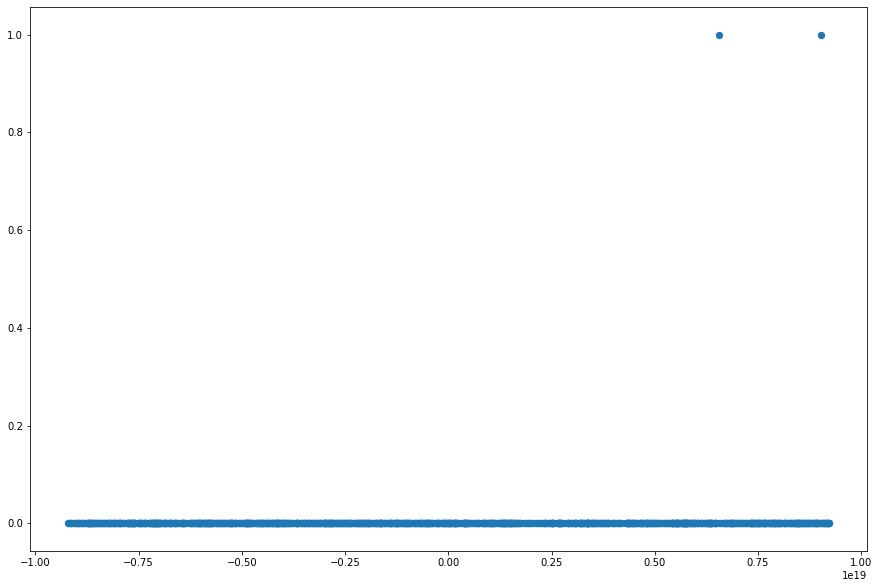

In [137]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

### 用随机产生的伪样本测试模型的有效性

In [153]:
pdDfFakeSamples = pd.DataFrame(data=np.random.randn(100, 32), index=["Fake"] * 100)

In [154]:
npAbnormalScores = fn_score(pdDfFakeSamples).values

In [155]:
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeandecode, fSigmadecode), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))
npAbnormalX = range(len(npAbnormalprob))

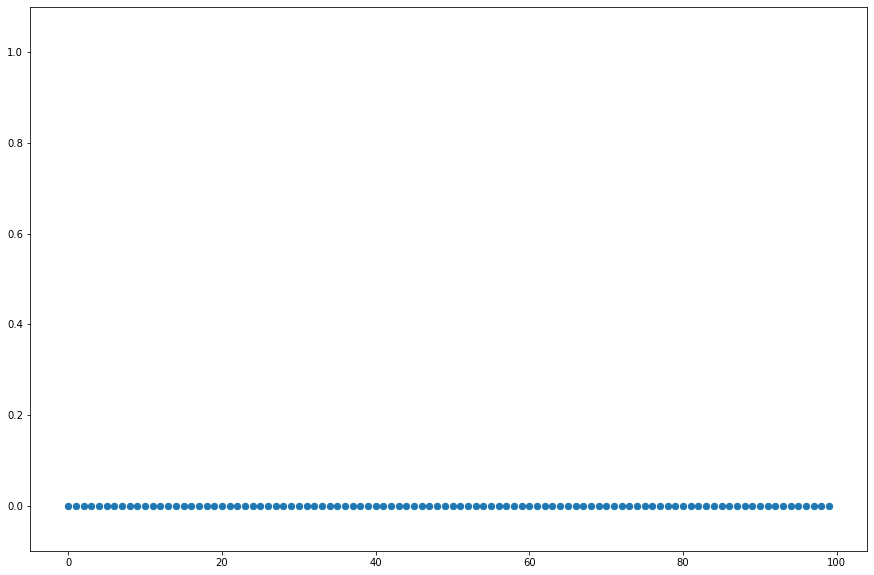

In [156]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.ylim([-0.1, 1.1])
plt.show()